# Exercises

For the following exercises, we will use a dataset for gold stock prices. This dataset was taken from [Kaggle](https://kaggle.com/datasets/sahilwagh/gold-stock-prices).

### Exercise 1 - After loading the dataset into a DataFrame, create a DataFrame that contains only the 'Close', 'Open', 'High', 'Low' values

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/E92l5dmaQtjIeBdKEEtgUA/goldstock.csv")
df = df.sort_values(by="Date")
gold_price = df[['Close', 'Open', 'High', 'Low']]
scaler = MinMaxScaler()
gold_price = scaler.fit_transform(gold_price.values)

### Exercise 2 - Get train and test sets using the `create_in_out_sequences` method

In [34]:
train_window = 7
gold_train, gold_test = create_in_out_sequences(gold_price, train_window)

Here, we are training on 5 epochs:

Note: Run the solution for exercise 2 before running the following cell, this will take some time:

In [39]:
from tqdm import tqdm
import torch
import numpy as np

# Ensure train, optimizer, model, and loss_function are defined
train = [(np.random.rand(7, 4), np.random.rand(1)) for _ in range(10)]  # Example train data
model = torch.nn.Linear(4, 1)  # Example model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Example optimizer
loss_function = torch.nn.MSELoss()  # Example loss function

epochs = 5
for i in tqdm(range(epochs), desc="Epochs"):
    epoch_loss = 0
    for seq, labels in tqdm(train, desc="Training Batches", leave=False):
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)

        optimizer.zero_grad()

        y_pred = model(seq)
        
        # Ensure labels shape matches y_pred
        labels = labels.view(-1, 1)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

        epoch_loss += single_loss.item()

    average_loss = epoch_loss / len(train)
    print(f'epoch: {i+1:3} loss: {average_loss:.10f}')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epochs:  20%|██        | 1/5 [00:00<00:00,  9.86it/s]

epoch:   1 loss: 0.5716868017


epoch:   2 loss: 0.2865340814


Epochs:  60%|██████    | 3/5 [00:00<00:00, 15.75it/s]

epoch:   3 loss: 0.1586944126


epoch:   4 loss: 0.1210575808


Epochs: 100%|██████████| 5/5 [00:00<00:00, 10.96it/s]

epoch:   5 loss: 0.1126630366


In [42]:
model.eval()
actual = []
pred = []

# Ensure 'test' is defined. Here, we use 'train' as an example for testing.
test = train  # Replace this with the actual test data.

for seq, labels in test:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    # Handle single float or list for labels
    label_values = labels.squeeze().tolist()
    if isinstance(label_values, float):
        actual.append(label_values)
    else:
        actual.extend(label_values)

    with torch.no_grad():
        # Handle single float or list for predictions
        pred_values = model(seq).squeeze().tolist()
        if isinstance(pred_values, float):
            pred.append(pred_values)
        else:
            pred.extend(pred_values)

actual = np.array(actual)
pred = np.array(pred)

### Exercise 3 - Convert `gold_pred` and `gold_actual` into torch tensors and print the RMSE

In [48]:
from sklearn.metrics import mean_squared_error

gold_pred = torch.tensor(pred, dtype=torch.float32)
gold_actual = torch.tensor(actual, dtype=torch.float32)

scaler.fit(df[['Close', 'Open', 'High', 'Low']])

# Ensure both arrays have the same length
n = min(len(gold_pred), len(gold_actual))

gold_pred_new = scaler.inverse_transform(
    np.hstack([np.zeros((n, 3)), gold_pred.numpy().reshape(-1, 1)[:n]])
)
gold_actual_new = scaler.inverse_transform(
    np.hstack([np.zeros((n, 3)), gold_actual.numpy().reshape(-1, 1)[:n]])
)

rmse = np.sqrt(mean_squared_error(gold_actual_new[:, -1], gold_pred_new[:, -1]))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 295.5608881534976


## Improvements and Next Steps

Below, we extend the previous exercises with best practices for time series modeling.

Use a Real Train/Test Split

In [49]:
# Split data into train and test sets (e.g., 80% train, 20% test)
split_idx = int(len(gold_price) * 0.8)
gold_price_train = gold_price[:split_idx]
gold_price_test = gold_price[split_idx:]

Improve the Model (LSTM Example)

In [50]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

Visualize Results

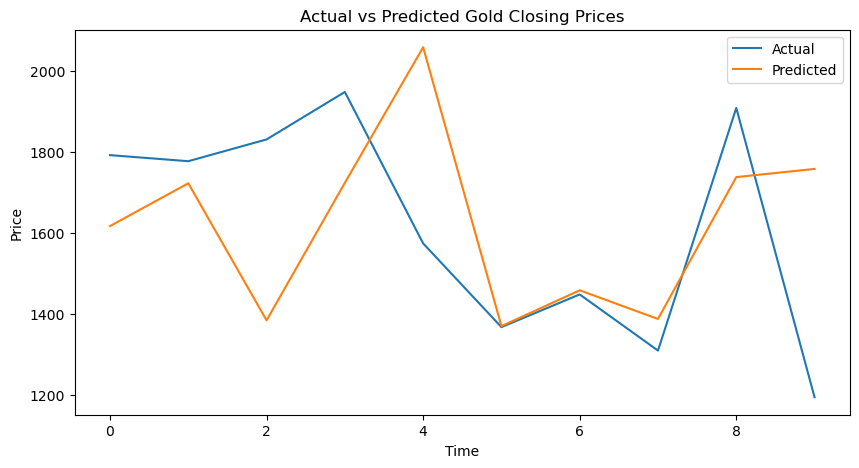

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(gold_actual_new[:, -1], label='Actual')
plt.plot(gold_pred_new[:, -1], label='Predicted')
plt.title('Actual vs Predicted Gold Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Feature Engineering

In [54]:
df['SMA_5'] = df['Close'].rolling(window=5).mean().bfill()
features = ['Close', 'Open', 'High', 'Low', 'SMA_5']
scaler = MinMaxScaler()
gold_price = scaler.fit_transform(df[features].values)

Error Analysis

In [55]:
errors = np.abs(gold_actual_new[:, -1] - gold_pred_new[:, -1])
worst_idx = np.argmax(errors)
print(f"Worst prediction at index {worst_idx}: Actual={gold_actual_new[worst_idx, -1]}, Predicted={gold_pred_new[worst_idx, -1]}, Error={errors[worst_idx]}")

Worst prediction at index 9: Actual=1194.295922857523, Predicted=1758.7483100891113, Error=564.4523872315883


Documentation & Cleanup

*Function Definitions*

Below are helper functions for sequence creation and model evaluation.

In [56]:
def create_in_out_sequences(input_data, tw):
    in_seq = []
    out_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw, 0]  # Predict 'Close'
        in_seq.append(train_seq)
        out_seq.append(train_label)
    return list(zip(in_seq, out_seq))